In [1]:
import torch
import torch.nn as nn


In [2]:
##reusing the multiheadattention class
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
    super().__init__()
    assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.w_query = nn.Linear(d_in,d_out,qkv_bias)
    self.w_key = nn.Linear(d_in,d_out,qkv_bias)
    self.w_value = nn.Linear(d_in,d_out,qkv_bias)
    self.out_proj = nn.Linear(d_out,d_out) # Corrected d_in to d_out
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length,context_length),diagonal=1)
    )

  def forward(self,x):
    b,num_tokens,d_in = x.shape
    keys = self.w_key(x)
    values = self.w_value(x)
    queries = self.w_query(x)
    ##splitting matrix by adding a num_heads and head_dim dimensions
    keys= keys.view(b,num_tokens,self.num_heads,self.head_dim)
    values = values.view(b,num_tokens,self.num_heads,self.head_dim)
    queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)

    #tranpsoing from shape (b,num_tokens,num_heads,head_dim) to (b,num_heads,num_tokens,head_dim)
    keys = keys.transpose(1,2)
    values = values.transpose(1,2)
    queries = queries.transpose(1,2)

    attn_scores = queries @ keys.transpose(2,3) # Fixed typo tranpose -> transpose
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0) # Added unsqueeze for broadcasting

    attn_scores.masked_fill_(mask_bool,-torch.inf)

    attn_weights = torch.softmax(
        attn_scores /keys.shape[-1]**0.5,dim=-1
    )
    attn_weights = self.dropout(attn_weights)

    context_vec_per_head = (attn_weights @ values).transpose(1,2) # Fixed typo tranpose -> transpose and renamed variable

    context_vec = context_vec_per_head.contiguous().view( # Used corrected variable name
        b,num_tokens,self.d_out
    )
    context_vec = self.out_proj(context_vec)
    return context_vec


In [3]:
## layernorm class
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1,keepdim=True)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift


In [4]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x,3))
    ))


In [5]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self,x):
    return self.layers(x)


In [6]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_size"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]

    )
    self.ffn = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x) # Fixed typo: dropout_shortcut -> drop_shortcut
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ffn(x) # Fixed typo: ff -> ffn
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x

In [7]:
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_size"],cfg["emb_dim"]) # Changed context_length to context_size
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]

    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"],bias=False
    )

  def forward(self,in_idx):
    batch_size,seq_len = in_idx.shape
    tok_embeds= self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_len,device=in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x) # Corrected dropout application
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [8]:
#from IPython.utils.process import get_output_error_code
GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_size":256,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_feature

* Here we have made some few adjustment to the `GPT_CONFIG_124M` dictionary by reducing the context size to 256 tokens.
* This modification reduces the computatioal demands of training the model, making it possible to carry out the training on a standard laptop cmputer

In [9]:
def generate_text(model,idx,max_new_tokens,context_size):
  for _ in range(max_new_tokens):
    # Crop idx to the last context_size tokens if it's longer
    idx_cond = idx[:,  -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:,-1,:]
    probs = torch.softmax(logits,dim=-1)
    idx_next = torch.argmax(probs,dim=-1,keepdim=True)
    idx = torch.cat((idx,idx_next),dim=1)
  return idx

In [10]:
##implementing text generation process
import tiktoken

def text_to_token_ids(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)# unsqueeze adds the batch dimension
  return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
  flat = token_ids.squeeze(0) #remove batch dimension
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text(
    model=model,
    idx=text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_size"]
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


* As we can see the model isn't yet producing coherent text because it hasn't undergone training.
* To define what makes text 'coherent' or 'high quality' we have to implement a numerical method to evaluate the generated content.

## 1.2  Calculating the text generation loss.

* Consider these two input examples, which have already been mapped to token IDs.

In [11]:
inputs = torch.tensor(
    [
        [16833,3626,6100], #every effort moves
        [40,1107,588] # I really like
    ]
)

* Matching these inpts, the targets contain token IDs we want the model to produce.

In [12]:
targets = torch.tensor([
    [3626,6100,345],#every effort moves you
    [1107,588,11311]#really like chocolate
])

* Note that these targets are inputs but shifted one position forward. This shifting strategy is crucial for teaching the model to predict the next token in a sequence.
* Next we feedthe inputs into the model to calculate logits vectors for the two input examples. The we apply the `softmax` function to transform these logits into probability scores.

In [13]:
with torch.no_grad():
  logits = model(inputs)
probs = torch.softmax(logits,dim=-1)
print(probs.shape)

torch.Size([2, 3, 50257])


In [14]:
##applying the argmax function to the probability scores to obtain the correspoding token IDs
token_ids = torch.argmax(probs,dim=-1,keepdim=True)
print("Token IDs:\n",token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


* Given that we have two input batches, each containing three tokens, applying `argmax` function to the probability scores yields two set of outputs, each with three predicted token Ids

In [15]:
##converting the token IDs back into text
print(f"Target batch1:{token_ids_to_text(targets[0],tokenizer)}")
print(f"Outputs batch1:"f"{token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

Target batch1: effort moves you
Outputs batch1: Armed heNetflix


* As we can see the model produces random text that is different from the target text because it has not been trained yet.
* Model training aims to increase the softmax probability in the index postions corresponding to the correct target token Ids.
* This softmax probability is also used in evaluation metric we will implement next to numerically access the model's generated outputs: higher probability in the correct positions, the better.

In [16]:
text_idx = 0
target_probs1 = probs[text_idx,[0,1,2],targets[text_idx]]
print("Text 1:",target_probs1)

text_idx = 1
target_probs2 = probs[text_idx,[0,1,2],targets[text_idx]]
print("Text 2: ",target_probs2)

Text 1: tensor([7.4514e-05, 3.1054e-05, 1.1567e-05])
Text 2:  tensor([1.0343e-05, 5.6737e-05, 4.7620e-06])


* The goal of training an LLM is to maximize relative likelihood of the current token, which involves increasing its probability relative to other tokens.
* This way, we ensure the LLM consistently picks the target token i.e the next word in the sentence as the next tokem it generates.

In [17]:
##calculating probability scores of the two example batches
log_probs =torch.log(torch.cat((target_probs1,target_probs2)))
print(log_probs)

tensor([ -9.5045, -10.3798, -11.3674, -11.4792,  -9.7771, -12.2549])


* Working with logarithms of the probabilities scores is more managable in mathematical optimization than handling the scores directly.

In [18]:
##combining the log probabilities into  single score by computing the averagr
avg_log_probs = torch.mean(log_probs)
print(avg_log_probs)

tensor(-10.7938)


* The goal is to get the average log probability as close to 0 as possilbe by updating the model's weights as part of the training process.
* However, in deep learning, the common practice isn't to push the average log probability up to 0 but rather to bring the negative average log probability to 0.
* The negative average log probability is simply the average log probability multiplied by -1 .

In [19]:
neg_avg_log_probs = avg_log_probs *-1
print(neg_avg_log_probs)

tensor(10.7938)


In [20]:
#recalling shape of the logits and target tensors
print("Logits shape: ",logits.shape) #dim=batch_size,num_tokens,vocab_size
print("Target shape: ",targets.shape)#batch_size and num_tokens

Logits shape:  torch.Size([2, 3, 50257])
Target shape:  torch.Size([2, 3])


In [21]:
##flattening tensors by combining them over the batch dimension
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flattened logits: ",logits_flat.shape)
print("Flattened targets: ",targets_flat.shape)

Flattened logits:  torch.Size([6, 50257])
Flattened targets:  torch.Size([6])


* Previously, we applied the softmax function, selected the probability scores corresponding to the target IDs, and computed the negative average log probabilites.
* Pytorch's `cross_entropy` function will take care of the these steps.

In [22]:
loss= torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.7938)


* The above resulting loss is the same that we obtained previously when applying the individual steps manually.

## 1.3 Calculating the trainig and validation set losses.

* We must first prepare the training and validation datasets that we will use to train the LLM.
* To compute loss, we use a very samll text dataset, the "Notes from the underground"

In [23]:
import urllib.request
url = "https://www.gutenberg.org/cache/epub/600/pg600.txt"
input_file ="pg600.txt"
urllib.request.urlretrieve(url, input_file)

('pg600.txt', <http.client.HTTPMessage at 0x7a9d137902c0>)

In [24]:
with open(input_file,'r',encoding='utf-8') as f:
  text_data = f.read()

In [25]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: ",total_characters)
print("Tokens:",total_tokens)

Characters:  259118
Tokens: 67308


In [26]:
##diving data into training and validation set
train_ratio = 0.90
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

* Using the `train_data` and `val_data` subsets, we can now create the respective dataloader reusing the `create_dataloader_v1` function

In [27]:
## creating a dataset for batched inputs and targets
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self,txt,tokenizer,max_length,stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt)##tokenizes text

    for i in range(0,len(token_ids) - max_length,stride):#using sliding window to chuk the book into overlapping sequences of max_length
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self,idx):
    return self.input_ids[idx], self.target_ids[idx]

In [28]:
## creating a dataloader to generate batches with input-with pairs
def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt,tokenizer,max_length,stride)
  dataloader = DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=drop_last,
      num_workers=num_workers
  )
  return dataloader

In [29]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_size"],
    stride=GPT_CONFIG_124M["context_size"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_size"],
    stride=GPT_CONFIG_124M["context_size"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [30]:
print("Train loader")
for x,y in train_loader:
  print(x.shape,y.shape)
print("\nValidation loader:")
for x,y in val_loader:
  print(x.shape,y.shape)

Train loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) 

In [31]:
##implementing a utility function to calculate the cross entropy loss
## of a given batch returned via the training and validation loader
def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0,1),target_batch.flatten()
  )
  return loss

In [32]:
##implementing a function to compute the training and validation loss
def calc_loss_loader(data_loader,model,device,num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")

  # Determine the actual number of batches to process
  if num_batches is None:
    actual_num_batches = len(data_loader)
  else:
    actual_num_batches = min(num_batches, len(data_loader))

  for i, (input_batch,target_batch) in enumerate(data_loader):
    if i < actual_num_batches:
      loss = calc_loss_batch(
          input_batch,target_batch,model,device
      )
      total_loss += loss.item()
    else:
      break
  # Avoid division by zero if actual_num_batches is 0
  if actual_num_batches == 0:
    return float("nan")
  return total_loss / actual_num_batches ##averaging loss over all batches


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader,model,device)
  val_loss = calc_loss_loader(val_loader,model,device)
print("Training loss:", train_loss)
print("Validation loss:",val_loss)

Training loss: 10.979752308180352
Validation loss: 10.972686608632406


* The loss values are relatively high because the model has not yet been trainied.

## 1.4 Training the LLM to generate human like text


In [40]:
def train_model(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):
  train_losses,val_losses,track_tokens_seen = [], [], []
  tokens_seen,global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()
    for input_batch,target_batch in train_loader:
      optimizer.zero_grad() #rest loss gradients from previous batch iterations
      loss = calc_loss_batch(
          input_batch,target_batch,model,device
      )
      loss.backward()
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss,val_loss = evaluate_model(
            model,train_loader,val_loader,eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(
            f"Ep {epoch+1} (Step {global_step:06d}):"
            f"Train Loss {train_loss:.3f},"
            f"Val loss {val_loss:.2f}"
        )
    generate(
       model,tokenizer,device,start_context
   )
  return train_losses,val_losses,track_tokens_seen


In [39]:
def evaluate_model(model,train_loader,val_loader,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader,model,device,num_batches=eval_iter
    )
    val_loss = calc_loss_loader(
        val_loader,model,device,num_batches=eval_iter
    )
  model.train()
  return train_loss,val_loss

In [36]:
def generate(model,tokenizer,device,start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context,tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text(
        model=model,
        idx=encoded,
        max_new_tokens=50,
        context_size=context_size
    )
  decoded_text =token_ids_to_text(token_ids,tokenizer)
  print(decoded_text.replace("\n"," "))
  model.train()

In [41]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,weight_decay=0.1
)
num_epochs = 10
train_losses,val_losses,tokens_seen = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="I am a sick",
    tokenizer=tokenizer
)

Ep 1 (Step 000000):Train Loss 9.905,Val loss 9.86
Ep 1 (Step 000005):Train Loss 8.366,Val loss 8.42
Ep 1 (Step 000010):Train Loss 7.244,Val loss 7.64
Ep 1 (Step 000015):Train Loss 6.927,Val loss 7.39
Ep 1 (Step 000020):Train Loss 6.880,Val loss 7.43
Ep 1 (Step 000025):Train Loss 6.651,Val loss 7.41
Ep 1 (Step 000030):Train Loss 6.837,Val loss 7.35
Ep 1 (Step 000035):Train Loss 6.775,Val loss 7.20
Ep 1 (Step 000040):Train Loss 6.496,Val loss 7.17
Ep 1 (Step 000045):Train Loss 6.331,Val loss 7.08
Ep 1 (Step 000050):Train Loss 6.154,Val loss 7.02
Ep 1 (Step 000055):Train Loss 5.990,Val loss 6.99
Ep 1 (Step 000060):Train Loss 6.182,Val loss 6.94
Ep 1 (Step 000065):Train Loss 6.158,Val loss 6.89
Ep 1 (Step 000070):Train Loss 6.055,Val loss 6.85
Ep 1 (Step 000075):Train Loss 5.944,Val loss 6.81
Ep 1 (Step 000080):Train Loss 6.000,Val loss 6.78
Ep 1 (Step 000085):Train Loss 5.729,Val loss 6.80
Ep 1 (Step 000090):Train Loss 6.010,Val loss 6.67
Ep 1 (Step 000095):Train Loss 5.633,Val loss 6.63


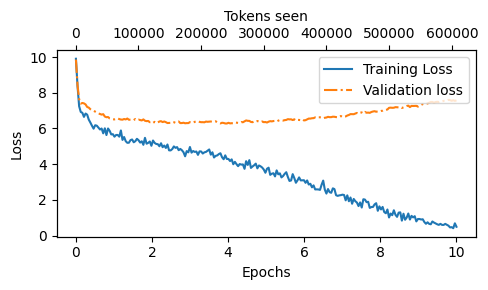

In [53]:
##plotting curves
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen,tokens_seen,train_losses,val_losses):
  fig,ax1 = plt.subplots(figsize=(5,3))
  ax1.plot(epochs_seen,train_losses,label="Training Loss")
  ax1.plot(epochs_seen,val_losses,linestyle="-.",label="Validation loss")

  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen,train_losses,alpha=0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()
epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)


##1.5 Decoding strategies to control randomness

In [42]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_feature

In [43]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text(
    model=model,
    idx=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_size"]

)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you funked the _real.

“So you rascal?”










## 1.5.1 Temperature scaling


* Temperature scaling is a technique that adds a probabilistic selection process to the next-token generatin task.
* In `generate_text` function, we always sampled tokens with the highest probability as the next new token using `torch.argmax`, also known as `greedy decoding`.
* To generate text with more variety, we can replace `argmax` with a function that samples from a probability distribution i.e here, the probability scores the LLM generates for each vocabulary entry at each token generation step.


In [44]:
vocab = {
    'closer':0,
    "every":1,
    'effort':2,
    "forward":3,
    "inches":4,
    "moves":5,
    "pizza":6,
    "toward":7,
    "you":8
}
inverse_vocab = {v:k for k,v in vocab.items()}

In [45]:
next_tokens_logits = torch.tensor(
     [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [47]:
probs = torch.softmax(next_tokens_logits,dim=0)
next_token_id = torch.argmax(probs).item()
print(inverse_vocab[next_token_id])

forward


* Since the largest logit value and, correspondingly, the largest softmax probabilitity score are in the fourth postion, the generated word is `forward`.
* To implement a probabilistic sampling process, we can now replace `argmax` with the `multinomial` function in pytorch.

In [48]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probs,num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


* The `multinomial` function smaples the next token proportional to its probability score.
* In other words "forward" is still the most likely token and will be selected by the `multinomial` most of the time but not all the time.

In [49]:
##implementing a function that repeats temp sampling 1000 times
def print_sampled_tokens(probs):
  torch.manual_seed(123)
  sample = [torch.multinomial(probs,num_samples=1).item() for i in range(1_000)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i, freq in enumerate(sampled_ids):
    print(f"{freq} x{inverse_vocab[i]}")
print_sampled_tokens(probs)

73 xcloser
0 xevery
0 xeffort
582 xforward
2 xinches
0 xmoves
0 xpizza
343 xtoward


* Here we see that "forward" has been sampled 582 times.
* We can further control the distribution and selection process via a concept called `temperature scaling`.


In [50]:
def softmax_with_temperature(logits,temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits,dim=0)

* Temperature greater than 1 result in more uniformity distributed token probabilities, and temperature smaller than 1 will result in more confident distributions.


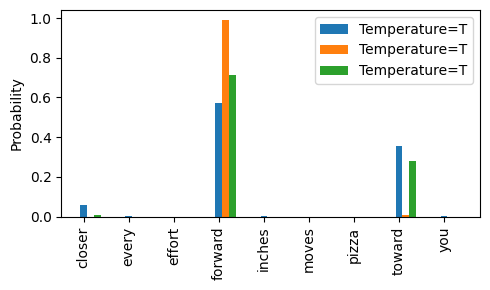

In [54]:
temperatures = [1,0.1,0.5]
scaled_probs = [softmax_with_temperature(next_tokens_logits,T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig,ax = plt.subplots(figsize=(5,3))
for i,T in enumerate(temperatures):
  rects = ax.bar(x+i * bar_width,scaled_probs[i],bar_width,label=f'Temperature={'T'}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(),rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

* A temperature of 1 divides the logits by 1 before passing them to the `softmax` function to compute the probability scores.
* For example,for the temperature setting 1, the token corresponding to `forward` would be selected about 60% of the time.

## 1.5.2 Top-k sampling

* In Top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process masking their probability scores.

In [55]:
top_k = 3
top_logits,top_pos = torch.topk(next_tokens_logits,top_k)
print("Top logits:",top_logits)
print("Top positions:",top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


* We can also apply, Pytorch's `where` function to set the logit values of tokens that are below the lowest logit value within our top-three selection to negative infinity (-inf).


In [57]:
new_logits = torch.where(
    condition=next_tokens_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_tokens_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [58]:
topk_probs = torch.softmax(new_logits,dim=0)
print(topk_probs)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## 1.5.3 Modifying thext generation functon with more diversity

In [59]:
def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:,-1,:]
    if top_k is not None:
      top_logits, _ = torch.topk(logits,top_k)
      min_val = top_logits[:,-1]
      logits = torch.where(
          logits < min_val,
          torch.tensor(float('-inf')).to(logits.device),
          logits
      )
    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits,dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)
    else:
      idx_next =torch.argmax(logits,dim=-1,keepdim=True)
    if idx_next == eos_id:
      break
    idx = torch.cat((idx,idx_next),dim=1)
  return idx


In [62]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("I am a sick man ",tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_size"],
    top_k=50,
    temperature=2.0
)

print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 I am a sick man as among anyone cameous. You may be corpulent or made us



## 1.5.4 Loading and saving weights in Pytorch

In [63]:
torch.save(model.state_dict(),"model.pth")

In [64]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth",map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_feature

In [65]:
#saving model and optimizer
torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict(),
},"model_and_optimizer.pth")

In [70]:
#restoring model and optimizer
checkpoint = torch.load("model_and_optimizer.pth",map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-4,weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_feature

## 1.5.5 Loading pretrained weights from OpenAI

In [71]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7a9aac279250>)

In [72]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size='124M',models_dir='gpt2'
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 226kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 634kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 274kiB/s]
model.ckpt.data-00000-of-00001:  37%|███▋      | 184M/498M [02:14<03:48, 1.37MiB/s]


Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.data-00000-of-00001) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M/model.ckpt.data-00000-of-00001


model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:28<00:00, 17.3MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.24MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 326kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 368kiB/s]


In [73]:
##inspecting contents of settings and params
print("Settings:",settings)
print("Parameter dictionary keys:",params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


* `Settings` stores the LLM architecture settings similar to the manually defined `GPT_CONFIG_124M` settings.
* The params contain the actual weight tensors.

In [74]:
print(params['wte'])
print("Token embedding weight tensor dimensions:",params['wte'].shape)


[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [75]:
##transferring GPT2 weights from setting and params dictionary into our defined GPTModel instance
# a dictionary showing the difference of GPT Model sizes
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [76]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [77]:
##updating tokens length from 256 to 1024
NEW_CONFIG.update({'context_size':1024})

In [78]:
##adding bias vector because  they were used in gpt2 computation of query,key and value vectors
NEW_CONFIG.update({"qkv_bias":True})

In [79]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=

In [80]:
##overriding random weights with weights we loaded into the params dictionary
# function that checks whether two tensors have similar dimensions or shape and returns right tensor as trainable Pytorch parameters
def assign(left,right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}," f"Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [87]:
#defining load_weight_into_gpt function that loads the weights from params dictionary into a GPTModel instance gpt

import numpy as np

def load_weights_into_gpt(gpt,params):
  gpt.pos_emb.weight = assign(
      gpt.pos_emb.weight,
      params['wpe']
  )
  gpt.tok_emb.weight = assign(
      gpt.tok_emb.weight,
      params['wte']
  )
  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
    (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.w_query.weight = assign(
        gpt.trf_blocks[b].att.w_query.weight, q_w.T
    )
    gpt.trf_blocks[b].att.w_key.weight = assign(
            gpt.trf_blocks[b].att.w_key.weight, k_w.T)
    gpt.trf_blocks[b].att.w_value.weight = assign(
           gpt.trf_blocks[b].att.w_value.weight, v_w.T)
    q_b, k_b, v_b = np.split(
         (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].att.w_query.bias = assign(
         gpt.trf_blocks[b].att.w_query.bias, q_b)
    gpt.trf_blocks[b].att.w_key.bias = assign(
          gpt.trf_blocks[b].att.w_key.bias, k_b)
    gpt.trf_blocks[b].att.w_value.bias = assign(
            gpt.trf_blocks[b].att.w_value.bias, v_b)
    gpt.trf_blocks[b].att.out_proj.weight = assign(
           gpt.trf_blocks[b].att.out_proj.weight,
           params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].att.out_proj.bias = assign(
        gpt.trf_blocks[b].att.out_proj.bias,
          params["blocks"][b]["attn"]["c_proj"]["b"])
    gpt.trf_blocks[b].ffn.layers[0].weight = assign(
           gpt.trf_blocks[b].ffn.layers[0].weight,
           params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[0].bias = assign(
              gpt.trf_blocks[b].ffn.layers[0].bias,
              params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ffn.layers[2].weight = assign(
             gpt.trf_blocks[b].ffn.layers[2].weight,
             params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[2].bias = assign(
            gpt.trf_blocks[b].ffn.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
    gpt.trf_blocks[b].norm1.scale = assign(
           gpt.trf_blocks[b].norm1.scale,
           params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
             gpt.trf_blocks[b].norm1.shift,
             params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
         gpt.trf_blocks[b].norm2.scale,
         params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
    gpt.trf_blocks[b].norm2.shift,
    params["blocks"][b]["ln_2"]["b"])

  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [88]:
load_weights_into_gpt(gpt,params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (w_query): Linear(in_features=

In [89]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("I am a sick",tokenizer).to(device),
    max_new_tokens=30,
    context_size=NEW_CONFIG["context_size"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 I am a sick man as the King can confirm that I was put within my office of having an election which I would vote to deny him. I told him by telling
